<a href="https://colab.research.google.com/github/Bstrutt/Moonboard-Analysis/blob/main/Moonboard_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
!pip install requests_html
import requests
from requests_html import HTMLSession
from json import JSONDecoder
import pandas as pd


     |████████████████████████████████| 83 kB 1.3 MB/s 
     |████████████████████████████████| 138 kB 28.2 MB/s 
     |████████████████████████████████| 111 kB 34.4 MB/s 
     |████████████████████████████████| 127 kB 35.7 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=ab7be2fd52813e668a999fcac7b81b1d3a239a4445005b7eb27c6efcbdfa7080
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=9cb5948629fcbfc00331d7e5e7422e866b8781f477aeb680e7ce6e9150d0927c
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
Successfully built fake-useragent parse
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not

### Helper Functions 

In [2]:
#This function taken directly from here: https://stackoverflow.com/questions/54235528/how-to-find-json-object-in-text-with-python
def extract_json_objects(text, decoder=JSONDecoder()):
    pos = 0
    while True:
        match = text.find('{', pos)
        if match == -1:
            break
        try:
            result, index = decoder.raw_decode(text[match:])
            return result
            pos = match + index
        except ValueError:
            pos = match + 1

In [3]:
def column(letter):
    if letter == 'A':
      return 0
    elif letter == 'B':
      return 1
    elif letter == 'C':
      return 2
    elif letter == 'D':
      return 3
    elif letter == 'E':
      return 4
    elif letter == 'F':
      return 5
    elif letter == 'G':
      return 6
    elif letter == 'H':
      return 7
    elif letter == 'I':
      return 8
    elif letter == 'J':
      return 9
    elif letter == 'K':
      return 10
    elif letter == 'L':
      return 11

In [4]:
def boardify(locationsList, typeList):
  board = [[0 for i in range(11)] for j in range(18)]
  for (loc, typ) in zip(locationsList, typeList):
    col = column(loc[0])
    row = 18 - int(loc[1:])
    board[row][col] = typ
  return board
  

In [5]:
def getBinaryBoard(board):
  binBoard = [[0 for i in range(11)] for j in range(18)]
  for i in range(0,len(board)):
    for j in range(len(board[i])):
      if board[i][j] != 0:
        binBoard[i][j] = 1
      else:
        binBoard[i][j] = 0
  return binBoard


In [6]:
def getCoords(locList):
  coords = []
  for loc in locList:
    col = column(loc[0])
    row = 18 - int(loc[1:])
    coords.append((row, col))
  return coords

### Scraping and dataframing

Our eventual output is a dataframe called 'routesDf'

The URL callouts can take a bit, usually around 3 minutes.

In [7]:
BASE = 'https://www.moonboard.com'
path = ''

session = HTMLSession()

In [8]:
routeJsons = []
file = open('benchmarkPaths', 'r')
Lines = file.readlines()

for line in Lines:
  url = BASE + line[:-1]
  response = session.get(url)
  text = response.text
  routeJsons.append(extract_json_objects(text))
routeJsons = routeJsons[:-1]

In [9]:
#Trying to test which of these is faster
grades = []
locations = []
holds = []
names = []
for route in routeJsons:
  grades.append(route['Grade'])
  names.append(route['Name'])
  locationDescriptions = []
  holdTypes = []
  for loc in route['Locations']:
    locationDescriptions.append(loc['Description'])
    holdTypes.append(loc['Type'])
  locations.append(locationDescriptions)
  holds.append(holdTypes)

In [10]:
routesDf = pd.DataFrame()

routesDf.insert(0, 'Name', names)
routesDf.insert(1, 'Grade', grades)
routesDf.insert(2, 'Locations', locations)
routesDf.insert(3, 'Hold Types', holds)


### EDA

A simple look at our data now that it's processed.

In [11]:
routesDf

,Name,Grade,Locations,Hold Types
0,BLACK BEAUTY,8B,"[E14, H18, I9, J5]","[2, 3, 2, 1]"
1,PROJECT 2,8A+,"[A16, A18, D10, H14, K6, K7]","[2, 3, 2, 2, 1, 2]"
2,SHATTERED MERCY,8A+,"[B4, C18, D3, G7, H15, H14, I8, K12]","[1, 3, 1, 2, 2, 2, 2, 2]"
3,ATTIC ADDICT,8A,"[A18, E6, F16, F15, F8, G2, J12, J6]","[3, 1, 2, 2, 2, 1, 2, 2]"
4,BUNNY,8A,"[B4, G7, G16, H18, H7, K8, K10, K13]","[1, 2, 2, 3, 2, 2, 2, 2]"
...,...,...,...,...
442,WARM UP NO. 8,6B+,"[E18, F13, F5, I10, I16, J12, J8]","[3, 2, 1, 2, 2, 2, 2]"
443,WUTHERING HEIGHTS,6B+,"[E15, E18, F5, G13, I11, J8, K11]","[2, 3, 1, 2, 2, 2, 2]"
444,YAYABLACK,6B+,"[C13, D18, D15, E8, H10, H5, J7, J5]","[2, 3, 2, 2, 2, 1, 2, 1]"
445,YOU GET A CAR,6B+,"[A9, C13, D12, E8, F14, F5, G14, G18, K5]","[2, 2, 2, 2, 2, 2, 2, 3, 1]"


A view of what a route looks like when it's on the wall. You can see the route here: https://www.moonboard.com/Problems/View/62575/project-2

0 = hold not included

1 = start

2 = default hold

3 = finish

In [12]:
routesDf['Full Board'] = ''
routesDf['Binary Board'] = ''
routesDf['Location Coords'] = ''
for i in routesDf.index:
  routesDf.at[i, 'Full Board'] = boardify(routesDf.at[i, 'Locations'], routesDf.at[i, 'Hold Types'])
  routesDf.at[i, 'Binary Board'] = getBinaryBoard(routesDf.at[i, 'Full Board'])
  routesDf.at[i, 'Location Coords'] = getCoords(routesDf.at[i, 'Locations'])

A look at our distribution of grades, because we have so little data at the higher end of our grades we will likely have trouble predicting in this area. Hopefully we'll still be able to predict the lower and middle ends of grades.

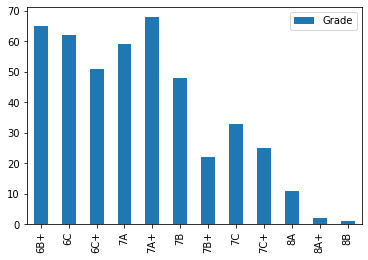

In [13]:
routesDf['Grade'].value_counts().to_frame().sort_index().plot(kind='bar')

### Feature Engineering

In [14]:
import math
def getCoordinateDistance(A, B):
  return abs(math.sqrt((A[0] - B[0])**2 + (A[1] - B[1])**2))


In [19]:
def averageSource(route):
  source = []
  for i in range(len(route['Hold Types'])):
    if route['Hold Types'][i] == 1:
      source.append(route['Location Coords'][i])
  sourceAverage = ((source[0][0] + source[1][0])/2, (source[0][1] + source[1][1])/2)
  return sourceAverage

In [16]:
def removeSource(route):
  vertices = []
  for i in range(len(route['Hold Types'])):
    if route['Hold Types'][i] != 1:
      vertices.append(route['Location Coords'][i])
  return vertices

In [17]:
#this is gonna be sloppy but here's what's going on. 
#We have tuples that are used in place of actual objects. (let's say it's because of speed)
#The first value is the x coordinate, the second is the y coordinate
#The third value is the dist value and the second is the prev value

def getHoldPath(route):
  sourceAverage = averageSource(route)
  vertices = removeSource(route)
  #If there are 2 sinks we need to reach both, otherwise single sink.
  sink = getSinks(route)

In [18]:
print(routesDf.iloc[2]['Location Coords'][2] )
print(routesDf.iloc[2]['Location Coords'][0] )
print(removeSource(routesDf.iloc[2]))

(15, 3)
(14, 1)
[(0, 2), (11, 6), (3, 7), (4, 7), (10, 8), (6, 10)]
